## Natural Language Processing

### Project : Fake News Detection

At the end of the project, the code will accept any user given text as input and will provide an estimate whether it's real or fake

we break the notebook into seperate steps :
* [Step 1](#step0): Import Libraries & Datasets
* [Step 2](#step1): Cleaning and Preprocessing
* [Step 3](#step2): Applying NLP Techniques
* [Step 4](#step3): Using Classification Model
* [Step 5](#step4): Creating Pipeline
* [Step 6](#step5): Predictions

---
<a id='step1'></a>
## Step 1 : Import Libraries & Datasets

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline
import nltk
import re 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
import pylab as pl
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
import joblib
from sklearn import linear_model
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

In [3]:
data = pd.read_csv("data.csv")
data.shape

(25000, 4)

In [4]:
data.head(5)

,index,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


Dataset with label '0' as fake news and '1' as real news 

<a id='step2'></a>
## Step 2 : Cleaning and Preprocessing

#### Checking for null values

In [5]:
data.isnull().sum()

index      0
title    155
text      12
label      0
dtype: int64

#### Replacing null value with space (' ')

In [6]:
data=data.fillna(' ')

#### Creating a new column, that will contain title of news, author name and the complete news

In [7]:
data['total']=data['title']+' '+data['text']

In [8]:
stop_words = stopwords.words('english')
lemmatizer=WordNetLemmatizer()

for index,row in data.iterrows():
    filter_sentence = ''
    sentence = row['total']
    sentence = re.sub(r'[^\w\s]','',sentence) 
    
    words = nltk.word_tokenize(sentence) 
    
    words = [w for w in words if not w in stop_words] 
    
    for word in words:
        filter_sentence = filter_sentence + ' ' + str(lemmatizer.lemmatize(word)).lower()
        
    data.loc[index,'total'] = filter_sentence


In [9]:
data = data[['total','label']]
data.head()

,total,label
0,law enforcement on high alert following threa...,1
1,did post vote hillary already,1
2,unbelievable obamas attorney general says mos...,1
3,bobby jindal raised hindu us story christian ...,0
4,satan 2 russia unvelis image terrifying new s...,1


In [10]:
data.shape

(25000, 2)

<a id='step3'></a>
## Step 3 : Applying NLP Techniques (converting text data to numeric data)

In [11]:
X_Data = data['total']
Y_Data = data['label']

#### Feature extraction using CountVectorizer and TfidfTransformer.

In [12]:
count_vectorizer = CountVectorizer()
count_vectorizer.fit_transform(X_Data)
freq_term_matrix = count_vectorizer.transform(X_Data) 
tfidf = TfidfTransformer(norm="l2")
tfidf.fit(freq_term_matrix)
tf_idf_matrix = tfidf.fit_transform(freq_term_matrix)

In [13]:
tf_idf_matrix

<25000x213094 sparse matrix of type '<class 'numpy.float64'>'
	with 5462217 stored elements in Compressed Sparse Row format>

#### Function to get the feature array

In [14]:
def vectorize_text(features, max_features):
    vectorizer = TfidfVectorizer( stop_words='english',
                            decode_error='strict',
                            analyzer='word',
                            ngram_range=(1, 2),
                            max_features=max_features               
                            )
    feature_vec = vectorizer.fit_transform(features)
    return feature_vec.toarray()

<a id='step4'></a>
## Step 4 : Using Classification Models

#### Plotting confusion matrix

In [15]:
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [16]:
tf_idf_matrix

<25000x213094 sparse matrix of type '<class 'numpy.float64'>'
	with 5462217 stored elements in Compressed Sparse Row format>

#### Train-test split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(tf_idf_matrix, Y_Data,test_size=0.30, random_state=20)

In [18]:
def confusion_metrics (conf_matrix):
    # save confusion matrix and slice into four pieces
    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    print('True Positives:', TP)
    print('True Negatives:', TN)
    print('False Positives:', FP)
    print('False Negatives:', FN)
    
    # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    
    # calculate mis-classification
    conf_misclassification = 1- conf_accuracy
    
    # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))
    # calculate the specificity
    conf_specificity = (TN / float(TN + FP))
    
    # calculate precision
    conf_precision = (TN / float(TN + FP))
    # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
    print('-'*50)
    print(f'Accuracy: {round(conf_accuracy,2)}') 
    print(f'Mis-Classification: {round(conf_misclassification,2)}') 
    print(f'Sensitivity/recall: {round(conf_sensitivity,2)}') 
    print(f'Specificity: {round(conf_specificity,2)}') 
    print(f'Precision: {round(conf_precision,2)}')
    print(f'f_1 Score: {round(conf_f1,2)}')


### Logistic Regression

Accuracy of Logistic Regression on training set: 0.97
Accuracy of Logistic Regression on test set: 0.95
True Positives: 3760
True Negatives: 3361
False Positives: 219
False Negatives: 160
--------------------------------------------------
Accuracy: 0.95
Mis-Classification: 0.05
Sensitivity/recall: 0.96
Specificity: 0.94
Precision: 0.94
f_1 Score: 0.95
Confusion matrix, without normalization
[[3361  219]
 [ 160 3760]]


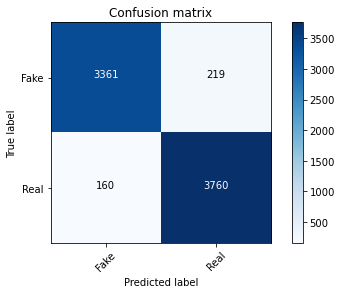

In [19]:
Lr = LogisticRegression()
Lr.fit(X_train, y_train)
pred = Lr.predict(X_test)
print('Accuracy of Logistic Regression on training set: {:.2f}'
     .format(Lr.score(X_train, y_train)))
print('Accuracy of Logistic Regression on test set: {:.2f}'
     .format(Lr.score(X_test, y_test)))
cm = confusion_matrix(y_test, pred)
np.set_printoptions(precision=2)
confusion_metrics(cm)

plt.figure()
plot_confusion_matrix(cm, classes=['Fake','Real'], normalize= False, title='Confusion matrix')

### MultinomialNB

Accuracy of NB  classifier on training set: 0.90
Accuracy of NB classifier on test set: 0.88
True Positives: 3362
True Negatives: 3225
False Positives: 355
False Negatives: 558
--------------------------------------------------
Accuracy: 0.88
Mis-Classification: 0.12
Sensitivity/recall: 0.86
Specificity: 0.9
Precision: 0.9
f_1 Score: 0.88
Confusion matrix, without normalization
[[3225  355]
 [ 558 3362]]


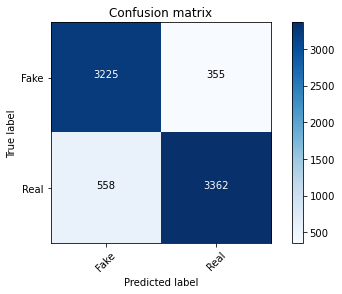

In [20]:
NB = MultinomialNB()
NB.fit(X_train, y_train)
pred = NB.predict(X_test)
print('Accuracy of NB  classifier on training set: {:.2f}'
     .format(NB.score(X_train, y_train)))
print('Accuracy of NB classifier on test set: {:.2f}'
     .format(NB.score(X_test, y_test)))
cm_NB = confusion_matrix(y_test, pred)
np.set_printoptions(precision=2)
confusion_metrics(cm_NB)

plt.figure()
plot_confusion_matrix(cm_NB, classes=['Fake','Real'], normalize= False, title='Confusion matrix')

<a id='step5'></a>
## Step 5 : Creating Pipeline

Assiging the variables again as once transformed vectors can't be transformed again using pipeline.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(data['total'], data['label'],test_size=0.3, random_state=20)

#### Creating Pipeline

In [22]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer(norm='l2')),
    ('clf', Lr),
])

In [23]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression())])

In [38]:
pipeline.predict(X_test)

array([0, 1, 1, ..., 0, 0, 0])

In [24]:
pipeline.predict(["flynn hillary clinton big woman campus breitbart daniel j flynnever get feeling life circle roundabout rather head straight line toward intended destination hillary clinton remains big woman campus leafy liberal wellesley massachusetts everywhere else vote likely inauguration dress remainder day way miss havisham forever wore wedding dress speaking great expectations hillary rodham overflowed 48 year ago first addressed wellesley graduating class the president college informed gathered 1969 student needed debate far i could ascertain spokesman kind like democratic primary 2016 minus term unknown even seven sisters school i glad miss adams made clear i speaking today u 400 u miss rodham told classmate after appointing edger bergen charlie mccarthys mortimer snerds attendance bespectacled granny glass awarding matronly wisdom least john lennon wisdom took issue previous speaker despite becoming first win election seat u s senate since reconstruction edward brooke came criticism calling empathy goal protestors criticized tactic though clinton senior thesis saul alinsky lamented black power demagogue elitist arrogance repressive intolerance within new left similar word coming republican necessitated brief rebuttal trust rodham ironically observed 1969 one word i asked class rehearsal wanted say everyone came said talk trust talk lack trust u way feel others talk trust bust what say what say feeling permeates generation perhaps even understood distrusted the trust bust certainly busted clintons 2016 plan she certainly even understand people distrusted after whitewater travelgate vast conspiracy benghazi missing email clinton found distrusted voice friday there load compromising road broadening political horizon and distrust american people trump edged 48 percent 38 percent question immediately prior novembers election stood major reason closing horizon clinton described vanquisher supporter embracing lie con alternative fact assault truth reason she failed explain american people chose lie truth as history major among today know well people power invent fact attack question mark beginning end free society offered that hyperbole like many people emerge 1960s hillary clinton embarked upon long strange trip from high school goldwater girl wellesley college republican president democratic politician clinton drank time place gave degree more significantly went idealist cynic comparison two wellesley commencement address show way back lamented long leader viewed politics art possible challenge practice politics art making appears impossible possible now big woman campus odd woman white house wonder current station even possible why arent i 50 point ahead asked september in may asks isnt president the woman famously dubbed congenital liar bill safire concludes lie mind getting stood election day like finding jilted bride wedding day inspires dangerous delusion"])

array([1])

In [25]:
joblib.dump(pipeline, 'pipe.joblib')

['pipe.joblib']

In [26]:
model = joblib.load('pipe.joblib')

<a id='step6'></a>
## Step 6 : Prediction

In [27]:
result = model.predict(["flynn hillary clinton big woman campus breitbart daniel j flynnever get feeling life circle roundabout rather head straight line toward intended destination hillary clinton remains big woman campus leafy liberal wellesley massachusetts everywhere else vote likely inauguration dress remainder day way miss havisham forever wore wedding dress speaking great expectations hillary rodham overflowed 48 year ago first addressed wellesley graduating class the president college informed gathered 1969 student needed debate far i could ascertain spokesman kind like democratic primary 2016 minus term unknown even seven sisters school i glad miss adams made clear i speaking today u 400 u miss rodham told classmate after appointing edger bergen charlie mccarthys mortimer snerds attendance bespectacled granny glass awarding matronly wisdom least john lennon wisdom took issue previous speaker despite becoming first win election seat u s senate since reconstruction edward brooke came criticism calling empathy goal protestors criticized tactic though clinton senior thesis saul alinsky lamented black power demagogue elitist arrogance repressive intolerance within new left similar word coming republican necessitated brief rebuttal trust rodham ironically observed 1969 one word i asked class rehearsal wanted say everyone came said talk trust talk lack trust u way feel others talk trust bust what say what say feeling permeates generation perhaps even understood distrusted the trust bust certainly busted clintons 2016 plan she certainly even understand people distrusted after whitewater travelgate vast conspiracy benghazi missing email clinton found distrusted voice friday there load compromising road broadening political horizon and distrust american people trump edged 48 percent 38 percent question immediately prior novembers election stood major reason closing horizon clinton described vanquisher supporter embracing lie con alternative fact assault truth reason she failed explain american people chose lie truth as history major among today know well people power invent fact attack question mark beginning end free society offered that hyperbole like many people emerge 1960s hillary clinton embarked upon long strange trip from high school goldwater girl wellesley college republican president democratic politician clinton drank time place gave degree more significantly went idealist cynic comparison two wellesley commencement address show way back lamented long leader viewed politics art possible challenge practice politics art making appears impossible possible now big woman campus odd woman white house wonder current station even possible why arent i 50 point ahead asked september in may asks isnt president the woman famously dubbed congenital liar bill safire concludes lie mind getting stood election day like finding jilted bride wedding day inspires dangerous delusion"])
if result == [0] :
  print('Fake News')
else :
  print('Real News')

Real News


In [37]:
news = "Just when you might have thought we d get a break from watching people kiss Donald Trump s ass and stroke his ego ad nauseam, a pro-Trump group creates an ad that s nothing but people doing even more of those exact things. America First Policies is set to release this ad, called  Thank You, President Trump,  on Christmas Day and, well, we threw up a little in our mouths trying to watch this.Basically, the spot is nothing but people fawning all over Trump for all the stuff he hasn t actually done. The ad includes a scene with a little girl thanking Trump for bringing back  Merry Christmas,  which never went away (there are even videos of President Obama saying  Merry Christmas  himself). A man thanks him for cutting his taxes. And America First says that everyday Americans everywhere are thanking Trump for being such a great and awesome president.The best president.Nobody s ever done what he s done. He s breaking all kinds of records every day.Believe us.Anyway, the word  propaganda  comes to mind when watching this. That s what it is   literal propaganda promoting someone who shouldn t need this kind of promotion anymore. Watch this ad bullshit below:The way the MAGAs are kowtowing to Orange Hitler is both disgusting and frightening. The man has done nothing, and his policies will harm the very same Americans who are thanking him. Unfortunately, it will take an obscene amount of pain before they ll open their eyes and see they ve been duped by a con man with a bad hairdo.And his ongoing need for this kind of adoration is, at best, unbecoming of his office. This ad is vile.Featured image via Al Drago-Pool/Getty Images"
result = model.predict([news])
if result == [1] :
  print('Real News')
else :
  print('Fake News')

Real News
